In [3]:
import os, pickle
import numpy as np
import copy

In [4]:
# 데이터 로드
# from LCN github - https://drive.google.com/drive/folders/1l-Xn5wiDd5ZcnClcqgiBCjHPp4ZjVVsY?usp=sharing
with open('h36m_test.pkl', 'rb') as f:
	data = pickle.load(f)

### 데이터 체크

In [5]:
len(data)

566920

In [6]:
data[0].keys()

dict_keys(['videoid', 'cameraid', 'camera_param', 'imageid', 'image_path', 'joint_3d_image', 'joint_3d_camera', 'center', 'scale', 'box', 'subject', 'action', 'subaction', 'root_depth', '2.5d_factor', 'joint_2.5d_image'])

In [7]:
keys = ['image_path', 'scale', '2.5d_factor', 'box', 'joint_2.5d_image', 'joint_3d_image', 'joint_3d_camera', 'root_depth', 'center']
for i in range(1):
    for key in keys:
        #print(key, type(data[i][key]))
        t = type(data[i][key])
        if t is np.ndarray:
            print(key, data[i][key].shape, data[i][key][0])
        elif t is np.float64:
            print(key, data[i][key])
        elif t is tuple:
            print(key, data[i][key])
        elif t is str:
            print(key, data[i][key])
    # print(data[i]['scale']) data[i]['2.5d_factor'], data[i]['scale'][0]*data[i]['scale'][1], data[i]['box'])
    # print(data[i]['joint_2.5d_image'][0])
    # print(data[i]['joint_3d_image'][0])
    # print(data[i]['joint_3d_image'][0]*data[i]['2.5d_factor'])
    # print(data[i]['joint_3d_camera'][0])
    # print(data[i]['root_depth'])

image_path s_09_act_02_subact_01_ca_01/s_09_act_02_subact_01_ca_01_000001.jpg
scale (2.0966154005537834, 2.0942930938593434)
2.5d_factor 4.656527137794738
box (4,) 241.30236162919766
joint_2.5d_image (17, 3) [2099.92564636 1888.20026799    0.        ]
joint_3d_image (17, 3) [450.96390168 405.49538575   0.        ]
joint_3d_camera (17, 3) [-293.70004272 -525.02728271 5461.41845703]
root_depth 5461.41845703125
center (450.963901684576, 405.49538574985655)


### calculate scaling factor

In [8]:
def get_rootrel_pose(pose):
    # input: pose (17, D)
    # output: rootrel_pose (17, D)
    root_pose = pose[0]
    rootrel_pose = pose - root_pose
    return rootrel_pose

# https://github.com/CHUNYUWANG/lcn-pose/blob/master/tools/gendb.py
def _weak_project(pose3d, fx, fy, cx, cy):
    pose2d = pose3d[:, :2] / pose3d[:, 2:3]
    pose2d[:, 0] *= fx
    pose2d[:, 1] *= fy
    pose2d[:, 0] += cx
    pose2d[:, 1] += cy
    return pose2d

# https://github.com/CHUNYUWANG/lcn-pose/blob/master/tools/gendb.py
def camera_to_image_frame(pose3d, box, camera, rootIdx):
    # x, y
    img_3d = np.zeros_like(pose3d)
    img_3d[:, :2] = _weak_project(
        pose3d.copy(), camera['fx'], camera['fy'], camera['cx'], camera['cy'])
    # z
    rectangle_3d_size = 2000.0
    ratio = (box[2] - box[0] + 1) / rectangle_3d_size
    pose3d_depth = ratio * (pose3d[:, 2] - pose3d[rootIdx, 2])
    img_3d[:, 2] = pose3d_depth
    img_2d = img_3d[:, :2]
    return img_2d, img_3d

# https://github.com/CHUNYUWANG/lcn-pose/blob/master/tools/gendb.py
def _infer_box(pose3d, camera, rootIdx):
    root_joint = pose3d[rootIdx, :]
    tl_joint = root_joint.copy()
    tl_joint[:2] -= 1000.0
    br_joint = root_joint.copy()
    br_joint[:2] += 1000.0
    tl_joint = np.reshape(tl_joint, (1, 3))
    br_joint = np.reshape(br_joint, (1, 3))
    #print(root_joint, tl_joint, br_joint)

    tl2d = _weak_project(tl_joint, camera['fx'], camera['fy'], camera['cx'],
                         camera['cy']).flatten()

    br2d = _weak_project(br_joint, camera['fx'], camera['fy'], camera['cx'],
                         camera['cy']).flatten()
    return np.array([tl2d[0], tl2d[1], br2d[0], br2d[1]])

def optimize_scaling_factor(cam_cs_hat, img_cs_hat, epochs=200, learningRate=0.00001):
    # https://towardsdatascience.com/linear-regression-with-pytorch-eb6dedead817
    import torch
    from torch.autograd import Variable
    class linearRegression(torch.nn.Module):
        def __init__(self, inputSize, outputSize):
            super(linearRegression, self).__init__()
            self.linear = torch.nn.Linear(inputSize, outputSize, bias=False)

        def forward(self, x):
            out = self.linear(x)
            return out

    x_train = copy.deepcopy(cam_cs_hat.reshape(-1, 1).astype(np.float32))
    y_train = copy.deepcopy(img_cs_hat.reshape(-1, 1).astype(np.float32))

    inputDim = 1        # takes variable 'x' 
    outputDim = 1       # takes variable 'y'

    model = linearRegression(inputDim, outputDim)
    #model.linear.weight.data[0] = 0.25

    criterion = torch.nn.MSELoss() 
    optimizer = torch.optim.SGD(model.parameters(), lr=learningRate)

    for epoch in range(epochs):
        # Converting inputs and labels to Variable
        if torch.cuda.is_available():
            inputs = Variable(torch.from_numpy(x_train))
            labels = Variable(torch.from_numpy(y_train))
        else:
            inputs = Variable(torch.from_numpy(x_train))
            labels = Variable(torch.from_numpy(y_train))

        # Clear gradient buffers because we don't want any gradient from previous epoch to carry forward, dont want to cummulate gradients
        optimizer.zero_grad()

        # get output from the model, given the inputs
        outputs = model(inputs)

        # get loss for the predicted output
        loss = criterion(outputs, labels)
        #print(loss)
        # get gradients w.r.t to parameters
        loss.backward()

        # update parameters
        optimizer.step()

        #print('epoch {}, loss {}'.format(epoch, loss.item()))
    return model.linear.weight.data.item()


In [9]:
# 논문에서 제공하는 2.5d_factor와 최적화 과정을 통해 구한 값의 에러 확인
error_lambda = 0
N = 10000
for i in range(N):
    print(i, end='\r')
    joint_3d_image = data[i]['joint_3d_image']
    joint_3d_camera = data[i]['joint_3d_camera']
    joint_25d_image = data[i]['joint_2.5d_image']
    scaling_factor = data[i]['2.5d_factor']
    camera_param = data[i]['camera_param']
    box = data[i]['box']

    assert joint_3d_image[0][0]*scaling_factor == joint_25d_image[0][0] # scaling factor 확인
    
    cam_3d = copy.deepcopy(joint_3d_camera)
    cam_3d_hat = get_rootrel_pose(cam_3d) # (17, 3) # root-relative pose 
    cam_2d_hat = copy.deepcopy(cam_3d_hat[:, :2]) # (17, 2) # root-relative pose
    
    # camera CS to image CS
    img_2d, img_3d = camera_to_image_frame(cam_3d, box, camera_param, 0) 
    img_25d = copy.deepcopy(joint_25d_image) # (17, 3)
    img_2d_hat = get_rootrel_pose(img_2d) # (17, 2) # root-relative pose 
    img_3d_hat = get_rootrel_pose(img_3d) # (17, 3) # root-relative pose 

    # optimize scaling factor for each frame -> lambda 위치가 어디에 곱해지느냐에 따라 결과가 달라짐
    #pred_lambda, losses = optimize_scaling_factor(img_2d_hat, cam_2d_hat) # x,y만 사용
    pred_lambda, losses = optimize_scaling_factor(img_3d_hat, cam_3d_hat) # x,y,z 사용
    
    #print("result: ", round(pred_lambda, 5), "gt: ", round(scaling_factor, 5))
    error_lambda += abs(round(pred_lambda, 5) - round(scaling_factor, 5))

print(error_lambda / float(N))


KeyboardInterrupt: 

### box 확인

In [10]:
i = 0
joint_3d_image = data[i]['joint_3d_image']
joint_3d_camera = data[i]['joint_3d_camera']
joint_25d_image = data[i]['joint_2.5d_image']
scaling_factor = data[i]['2.5d_factor']
camera_param = data[i]['camera_param']
box = data[i]['box']

assert joint_3d_image[0][0]*scaling_factor == joint_25d_image[0][0] # scaling factor 확인

cam_3d = copy.deepcopy(joint_3d_camera)
cam_3d_hat = get_rootrel_pose(cam_3d) # (17, 3) # root-relative pose 
cam_2d_hat = copy.deepcopy(cam_3d_hat[:, :2]) # (17, 2) # root-relative pose

# camera CS to image CS
img_2d, img_3d = camera_to_image_frame(cam_3d, box, camera_param, 0) 
img_25d = copy.deepcopy(joint_25d_image) # (17, 3)
img_2d_hat = get_rootrel_pose(img_2d) # (17, 2) # root-relative pose 
img_3d_hat = get_rootrel_pose(img_3d) # (17, 3) # root-relative pose 

# optimize scaling factor for each frame -> lambda 위치가 어디에 곱해지느냐에 따라 결과가 달라짐
#pred_lambda, losses = optimize_scaling_factor(img_2d_hat, cam_2d_hat) # x,y만 사용
pred_lambda, losses = optimize_scaling_factor(img_3d_hat, cam_3d_hat) # x,y,z 사용

In [11]:
box, _infer_box(cam_3d, camera_param, 0)

(array([241.30236163, 196.06607636, 660.62544174, 614.92469514]),
 array([241.30236163, 196.06607636, 660.62544174, 614.92469514]))

In [12]:
box[2] - box[0] + 1

420.3230801107567

In [13]:
rectangle_3d_size = 2000.0
ratio = (box[2] - box[0] + 1) / rectangle_3d_size
ratio

0.21016154005537835

In [14]:
ratio*(cam_3d[:, 2] - cam_3d[0, 2])

array([  0.        ,   8.82873442,  22.07004024,  22.32114634,
        -8.82904228,   2.5169102 ,  -3.42836274, -12.33313706,
       -25.37310648, -20.50511667, -35.28815441, -44.31740429,
       -66.06594253, -70.10467677, -11.45575367,  15.07447269,
        47.65566848])

### 관계 확인

In [15]:
(joint_3d_image == img_3d).min()

True

In [16]:
(joint_3d_image * pred_lambda) == joint_25d_image # 반올림 필요

array([[False, False,  True],
       [False, False, False],
       [False, False, False],
       [False, False, False],
       [False, False, False],
       [False, False, False],
       [False, False, False],
       [False, False, False],
       [False, False, False],
       [False, False, False],
       [False, False, False],
       [False, False, False],
       [False, False, False],
       [False, False, False],
       [False, False, False],
       [False, False, False],
       [False, False, False]])

In [17]:
(np.round(joint_25d_image) == np.round(img_3d * pred_lambda)).min()

True

### Visualization

In [18]:
import cv2
from matplotlib import pyplot as plt

#### 2d image

In [19]:
# https://github.com/Vegetebird/MHFormer/blob/main/demo/vis.py
def get_2d_pose_image(kps, img, box=None):
    connections = [[0, 1], [1, 2], [2, 3], [0, 4], [4, 5],
                   [5, 6], [0, 7], [7, 8], [8, 9], [9, 10],
                   [8, 11], [11, 12], [12, 13], [8, 14], [14, 15], [15, 16]]

    LR = np.array([0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0], dtype=bool)

    lcolor = (255, 0, 0)
    rcolor = (0, 0, 255)
    thickness = 3

    for j,c in enumerate(connections):
        start = map(int, kps[c[0]])
        end = map(int, kps[c[1]])
        start = list(start)
        end = list(end)
        cv2.line(img, (start[0], start[1]), (end[0], end[1]), lcolor if LR[j] else rcolor, thickness)
        cv2.circle(img, (start[0], start[1]), thickness=-1, color=(0, 255, 0), radius=3)
        cv2.circle(img, (end[0], end[1]), thickness=-1, color=(0, 255, 0), radius=3)
        if box is not None:
            box = box.astype(int)
            cv2.rectangle(img, (box[0], box[1]), (box[2], box[3]), (0, 255, 0), 2)

    return img

def plot_cv2_image(img):
    #plt.axis('off')
    plt.imshow(img)
    plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


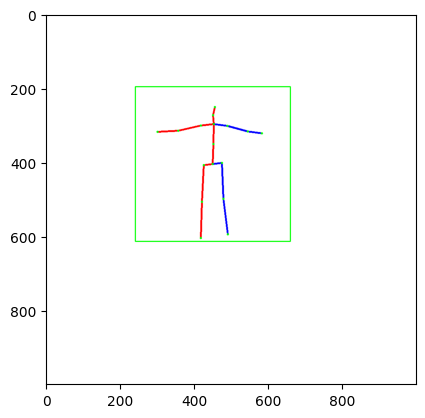

In [20]:
# img_2d
img = np.ones([1000, 1000, 3])
img = get_2d_pose_image(img_2d, img, box)
plot_cv2_image(img)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


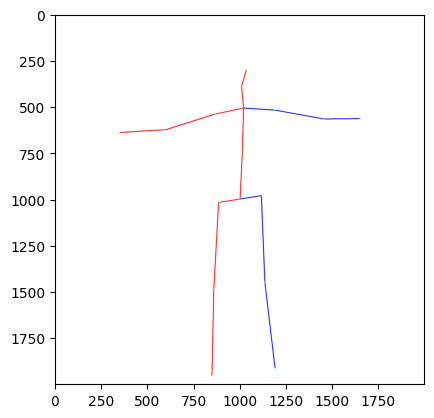

In [21]:
# img_2d
img = np.ones([2000, 2000, 3])
img = get_2d_pose_image(cam_3d_hat[:, :2] + 1000, img)
plot_cv2_image(img)

#### 3d image

In [22]:
import matplotlib
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.gridspec as gridspec

plt.switch_backend('TkAgg')
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

In [23]:
# https://github.com/Vegetebird/MHFormer/blob/main/demo/vis.py
def show3Dpose(pose, ax):
    joint_pairs = [[0, 1], [1, 2], [2, 3], [0, 4], [4, 5], [5, 6], [0, 7], [7, 8], [8, 9], [8, 11], [8, 14], [9, 10], [11, 12], [12, 13], [14, 15], [15, 16]]
    joint_pairs_left = [[8, 11], [11, 12], [12, 13], [0, 4], [4, 5], [5, 6]]
    joint_pairs_right = [[8, 14], [14, 15], [15, 16], [0, 1], [1, 2], [2, 3]]

    color_mid = "#00457E"
    color_left = "#02315E"
    color_right = "#2F70AF"

    j3d = pose
    
    # plt.tick_params(left = True, right = True , labelleft = False ,
    #                 labelbottom = False, bottom = False)
    # 좀 더 보기 좋게 하기 위해 y <-> z, - 붙임
    for i in range(len(joint_pairs)):
        limb = joint_pairs[i]
        xs, ys, zs = [np.array([j3d[limb[0], j], j3d[limb[1], j]]) for j in range(3)]
        if joint_pairs[i] in joint_pairs_left:
            ax.plot(-xs, -zs, -ys, color=color_left, lw=3, marker='o', markerfacecolor='w', markersize=3, markeredgewidth=2) # axis transformation for visualization
        elif joint_pairs[i] in joint_pairs_right:
            ax.plot(-xs, -zs, -ys, color=color_right, lw=3, marker='o', markerfacecolor='w', markersize=3, markeredgewidth=2) # axis transformation for visualization
        else:
            ax.plot(-xs, -zs, -ys, color=color_mid, lw=3, marker='o', markerfacecolor='w', markersize=3, markeredgewidth=2) # axis transformation for visualization

def show3Dbox(root_joint, offset, ax):
    top_left = copy.deepcopy(root_joint)
    top_left[:2] -= offset
    top_right = copy.deepcopy(root_joint)
    top_right[0] -= offset
    top_right[1] += offset
    bottom_right = copy.deepcopy(root_joint)
    bottom_right[:2] += offset
    bottom_left = copy.deepcopy(root_joint)
    bottom_left[0] += offset
    bottom_left[1] -= offset
    ax.plot(-top_left[0], -top_left[2], -top_left[1], marker='o', markersize=3)
    ax.plot(-bottom_right[0], -bottom_right[2], -bottom_right[1], marker='o', markersize=3)
    ax.plot(-top_right[0], -top_right[2], -top_right[1], marker='o', markersize=3)
    ax.plot(-bottom_left[0], -bottom_left[2], -bottom_left[1], marker='o', markersize=3)


In [24]:
# cam_3d with box
min_, max_ = -2000, 2000
fig = plt.figure(0, figsize=(10, 10))
ax = plt.axes(projection="3d")
ax.set_xlim(0, max_)
ax.set_ylim(min_, 0)
ax.set_zlim(0, max_)
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
ax.view_init(elev=12., azim=80)
show3Dpose(cam_3d, ax)
show3Dbox(cam_3d[0], 1000, ax)
plt.savefig('cam_3d.png')

In [25]:
# img_25d
min_, max_ = -2000, 2000
fig = plt.figure(0, figsize=(10, 10))
ax = plt.axes(projection="3d")
ax.set_xlim(min_, max_)
ax.set_ylim(min_, max_)
ax.set_zlim(min_, max_)
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
ax.view_init(elev=12., azim=80)
show3Dpose(img_25d, ax)
plt.savefig('img_25d.png')

In [26]:
# cam_3d_hat
fig = plt.figure(0, figsize=(10, 10))
ax = plt.axes(projection="3d")
ax.set_xlim(-512, 512)
ax.set_ylim(-512, 512)
ax.set_zlim(-512, 512)
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
ax.view_init(elev=12., azim=80)
show3Dpose(cam_3d_hat, ax)
plt.savefig('cam_3d_hat.png')

In [27]:
# img_3d
fig = plt.figure(0, figsize=(10, 10))
ax = plt.axes(projection="3d")
ax.set_xlim(-512, 512)
ax.set_ylim(-512, 512)
ax.set_zlim(-512, 512)
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
ax.view_init(elev=12., azim=80)

show3Dpose(img_3d, ax)
plt.savefig('img3d.png')

In [28]:
# img_3d_hat
fig = plt.figure(0, figsize=(10, 10))
ax = plt.axes(projection="3d")
ax.set_xlim(-512, 512)
ax.set_ylim(-512, 512)
ax.set_zlim(-512, 512)
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
ax.view_init(elev=12., azim=80)

show3Dpose(img_3d_hat, ax)
plt.savefig('img_3d_hat.png')

In [29]:
# img_3d vs img_25d
fig = plt.figure(0, figsize=(10, 10))
ax = plt.axes(projection="3d")
ax.set_xlim(-512, 512)
ax.set_ylim(-512, 512)
ax.set_zlim(-512, 512)
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
ax.view_init(elev=12., azim=80)

show3Dpose(img_3d_hat, ax)
show3Dpose(get_rootrel_pose(img_25d), ax)
plt.savefig('img_3d_vs_img_25d.png')

In [30]:
# img_3d x scale vs img_25d
fig = plt.figure(0, figsize=(10, 10))
ax = plt.axes(projection="3d")
ax.set_xlim(-512, 512)
ax.set_ylim(-512, 512)
ax.set_zlim(-512, 512)
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
ax.view_init(elev=12., azim=80)

show3Dpose(img_3d_hat * pred_lambda, ax)
show3Dpose(get_rootrel_pose(img_25d), ax)
plt.savefig('img_3dxscale_vs_img_25d.png')

In [31]:
# cam_3d vs img_3d x scale (= img_25d)
fig = plt.figure(0, figsize=(10, 10))
ax = plt.axes(projection="3d")
ax.set_xlim(-512, 512)
ax.set_ylim(-512, 512)
ax.set_zlim(-512, 512)
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
ax.view_init(elev=12., azim=80)

show3Dpose(img_3d_hat * pred_lambda, ax)
show3Dpose(cam_3d_hat, ax)
plt.savefig('img_3dxscale_vs_cam_3d.png')